## Sagnac Frequency - Phase Jump Detection

...

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [12]:
def __get_trace(seed):

    from obspy import Trace
    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

## Configurations

In [112]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-23 00:00")
config['tend'] = UTCDateTime("2024-05-26 00:00")

# config['tbeg'] = UTCDateTime("2024-05-31 00:00")
# config['tend'] = UTCDateTime("2024-06-01 00:00")

flim1, flim2 = 447.726, 447.745

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

# specify sampling rate of rotation rate data
config['sampling_rate'] = 20 # Hz

# compute expected number of samples
config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] =  data_path+"stationxml_ringlaser/dataless/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [113]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

In [127]:
def get_phase_jumps_sta_lta(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    mask = np.array(detect)

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2), mask

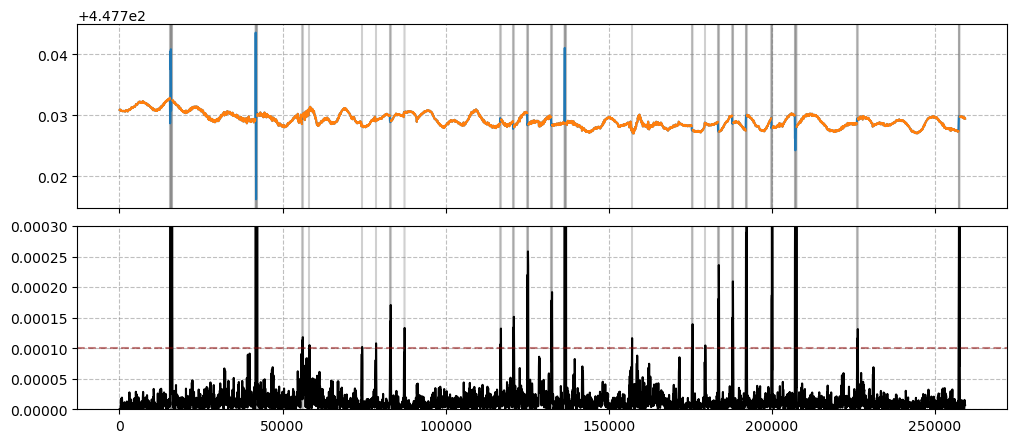

In [162]:

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect, mask = get_phase_jumps_sta_lta(data0, time0, 5, 3, amp_threshold=0.0001)

# apply mask
bs['fj_fs_mask'] = bs.fj_fs*mask


In [116]:
mask1 = np.where(detect == 1, bs.time1, np.nan)
mask2 = np.where(detect == 1, bs.time2, np.nan)

mask_df = DataFrame()
mask_df['mask1'] = mask1
mask_df['mask2'] = mask2

mask_df = mask_df.dropna()

mask1 = np.array(mask_df.mask1)
mask2 = np.array(mask_df.mask2)

In [117]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

## Correct for phase jumps

In [118]:
def __reduce_phase_jumps(data, detect):

    data = np.array(data)

    for _i in range(len(data)):

        if detect[_i] == 1:
            left = np.nanmean(data[_i-8:_i-3])
            right = np.nanmean(data[_i+3:_i+8])

            diff = left - right

            data[_i-3:_i] = left

            data[_i:] += diff

    return data

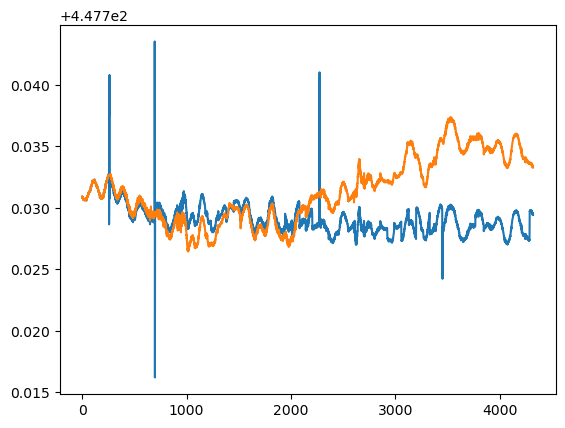

In [160]:

bs['fj_fs_dejump'] = __reduce_phase_jumps(bs.fj_fs, detect)

plt.plot(bs.fj_fs)
plt.plot(bs.fj_fs_dejump)

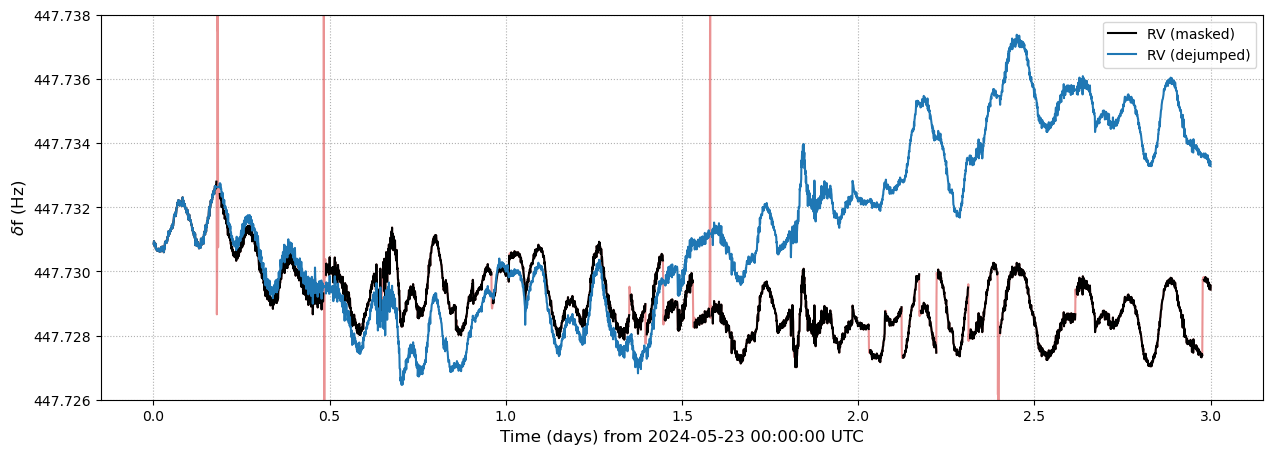

In [166]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/86400, "days"

    ax.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:red", alpha=0.5)
    ax.plot(bs.time_sec*tscale, bs.fj_fs_mask, color="black", label="RV (masked)")
    ax.plot(bs.time_sec*tscale, bs.fj_fs_dejump, color="tab:blue", label="RV (dejumped)")

    # for d in detect*bs.time_sec*tscale:
    #     ax.axvline(d, alpha=0.5, zorder=1, color="tab:purple")

    ax.ticklabel_format(useOffset=False)

    ax.set_ylim(447.726, 447.738)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)

    ax.set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_dejump.png", format="png", dpi=150, bbox_inches='tight')


In [167]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec, bs.fj_fs_mask, color="black")

    ax[1].plot(bs.time_sec, bs.fj_fs_mask, color="black")
    ax[1].plot(bs.time_sec, bs.fj_fs_dejump, color="tab:blue")

    for d in detect*bs.time_sec:
        ax[0].axvline(d, alpha=0.5, zorder=1, color="tab:purple")

    ax[0].ticklabel_format(useOffset=False)
    ax[1].ticklabel_format(useOffset=False)

    ax[0].set_ylim(447.726, 447.734)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

# fig = __makeplot();


In [96]:
import obspy as obs

tr_mask = __get_trace("BW.ROMY.30.MLT")

tr_mask.data = __mlti_intervals_to_zero(tr_mask.data,
                                         tr_mask.times(reftime=config['t1'], type="utcdatetime"),
                                         mask1,
                                         mask2,
                                         t_offset_sec=60,
                                         )

1440 1440


(0.5, 44.33653761636835)

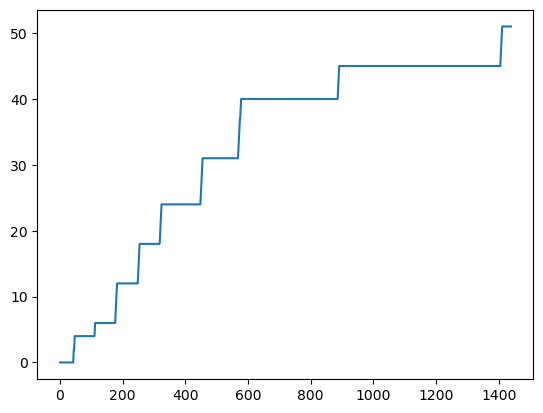

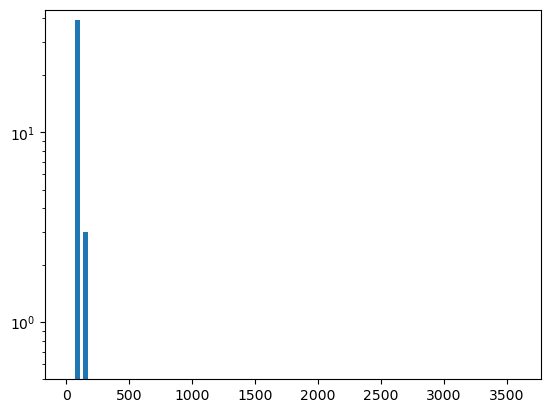

In [49]:
print(len(bs.fj_fs), len(detect))


mask = np.where(detect==1, 1, 0)

time_mask = time0 * detect

time_inter = time_mask[time_mask != 0]

inter = np.diff(time_inter)
inter[0] = inter[1]

plt.figure()
plt.plot(np.cumsum(detect))

NN = 3600
plt.figure()
plt.hist(inter, bins=int(NN/60), range=(0, NN), log=True, rwidth=0.7)
plt.ylim(bottom=0.5)

invalid command name "140618524786432delayed_destroy"
    while executing
"140618524786432delayed_destroy"
    ("after" script)
invalid command name "140618529335360delayed_destroy"
    while executing
"140618529335360delayed_destroy"
    ("after" script)


In [45]:
def __get_jumps_from_phase(arr, time, fraction_of_pi=6, plot=True):

    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.signal import hilbert


    def smooth(y, npts):
        '''
        moving average of 1d signal for n samples
        '''
        win = np.hanning(npts)
        y_smooth = np.convolve(y, win/np.sum(win), mode='same')
        y_smooth[:npts//2] = np.nan
        y_smooth[-npts//2:] = np.nan
        return y_smooth

    data = arr.copy()

    # define threshold for phase jump identification
    threshold = np.pi/fraction_of_pi

    # remove mean of data to avoid jumps at start and end
    data -= np.nanmean(data)

    # avoid having to deal with nan values
    data = np.nan_to_num(data, nan=0)

    # compute Hilbert transform
    H = hilbert(data)

    # obtain angle of hilibert
    # pha = np.angle(H)
    pha = np.unwrap(np.angle(H))

    # derivative of angle
    dpha = np.gradient(pha, edge_order=1)

    # dpha /= np.real(H)
    # dpha /= max(abs(pha))
    # dpha /= sum((np.gradient(test)))

    dpha = abs(dpha)

    # detect phase changes
    dpha_y = [_x if abs(_x) > threshold and abs(_x) < 3.14 else np.nan for _x in dpha]

    # detect phase indices
    dpha_idx = [list(dpha).index(_x) for _x in dpha if abs(_x) > threshold and abs(_x) < 3.14]

    # apply filter
    out = [np.nan if _i in dpha_idx else arr[_i] for _i in range(len(arr))]

    # checkup plot
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 8))

        ax[0].plot(time, dpha)
        ax[0].scatter(time, dpha_y, color="tab:orange", s=10, zorder=2)
        ax[0].axhline(threshold, color="red", ls="--", alpha=0.5)
        # ax[0].axhline(-threshold, color="red", ls="--", alpha=0.5)

        ax[1].plot(time, data)
        for line in time[dpha_idx]:
            ax[1].axvline(line, -1000, 1000, zorder=0, alpha=0.3, color="tab:orange")

        plt.show();

    return np.array(out), time[dpha_idx], np.array(dpha_y)[dpha_idx], np.array(dpha_idx)

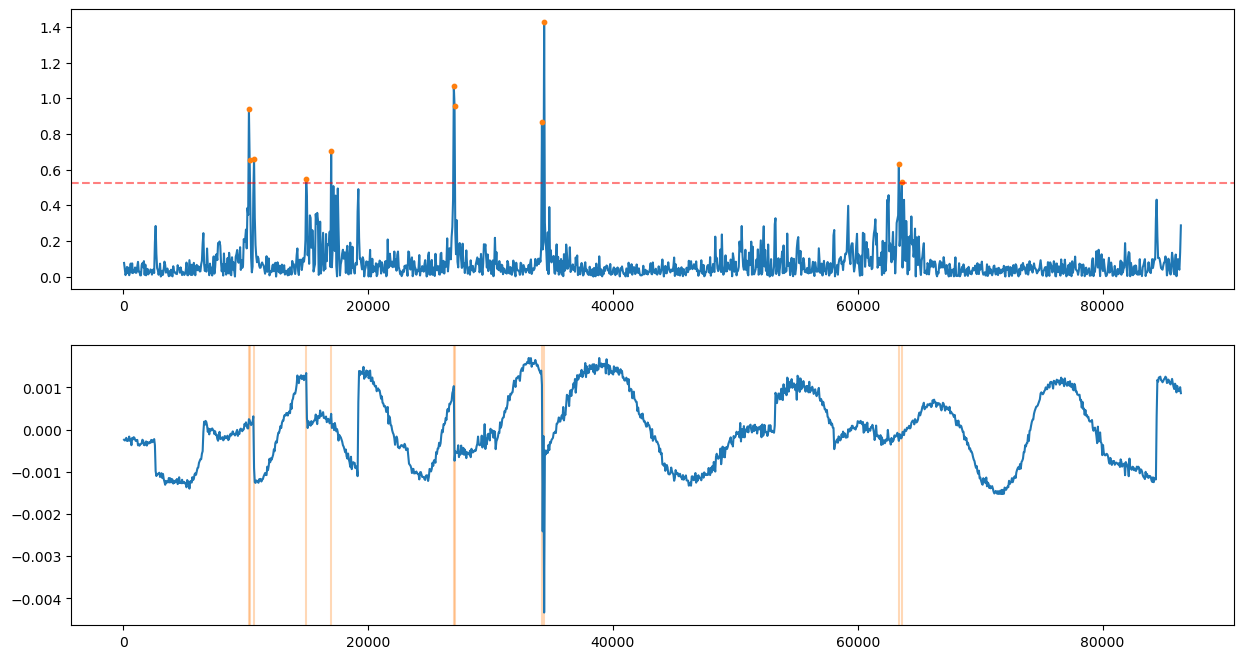

In [47]:

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

data_new, time_new, spikes, idx = __get_jumps_from_phase(data0, time0, fraction_of_pi=6)

### Load rotation rate data

In [ ]:
romy_inv = read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

st0 = Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

# st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

In [ ]:
st0.plot(equal_scale=False);

## Despike using Image

In [ ]:
V = st0.copy().select(component="V").trim(config['tbeg'], config['tend'], nearest_sample=False)[0].data

In [ ]:
from functions.despike_image import *
from functions.get_time_intervals import __get_time_intervals
from tqdm.notebook import tqdm

tinterval = 3600
ninterval = 20*tinterval

times = __get_time_intervals(config['tbeg'], config['tend'], tinterval, 0)


_spikes = np.zeros(int((config['tend'] - config['tbeg'])*20))
_cleans = np.zeros(int((config['tend'] - config['tbeg'])*20))

n2 = 0
for _k, (t1, t2) in enumerate(tqdm(times)):

    _V = st0.select(component="V").copy().trim(t1, t2, nearest_sample=False)[0].data

    # get amount of samples of subdata
    NV = len(_V)

    if _k == 0:
        n1, n2 = 0, NV

    # get image for signal
    Vimg, Npad = signal_to_image(_V)

    # get absolute image
    aVimg = abs(Vimg)

    # find spikes
    Vimg_clean, Vimg_spikes = clean(Vimg, mask='mean', size=15, n=10, fill_method='median', fill_size=2, thres=1e-8)

    # turn image to signal
    _cleans[n1:n2] = image_to_signal(Vimg_clean, pad=Npad)
    _spikes[n1:n2] = image_to_signal(Vimg_spikes, pad=Npad)

    n1, n2 = n1+NV, n2+NV

V_filt = _cleans
spikes = _spikes

In [ ]:

# create mask from spikes
mask = get_mask(spikes)

# smooth mask
mask_smooth = smooth(mask, 10)

# apply mask
V_masked = V * mask_smooth


In [ ]:
def __makeplot():
    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec

    fig = plt.figure(layout="constrained", figsize=(15, 10))

    gs = GridSpec(3, 3, figure=fig)

    ax1 = fig.add_subplot(gs[:1, :])
    ax2 = fig.add_subplot(gs[1, 0:1])
    ax3 = fig.add_subplot(gs[1, 1:2])
    ax4 = fig.add_subplot(gs[1, 2:3])

    # fig.suptitle("GridSpec")

    cmap1 = plt.get_cmap('viridis')

    vmin, vmax = 0, 1e-8
    #max(aVimg.reshape(aVimg.shape[0]*aVimg.shape[1]))

    ax1.plot(V)
    ax1.plot(V_masked)
    # for sp in spikes:
    #     ax1.axvline(sp, color="grey", zorder=1, alpha=0.6)

    ax2.imshow(aVimg, cmap=cmap1, vmin=vmin, vmax=vmax)
    ax3.imshow(Vimg_spikes, cmap=plt.get_cmap('gray'))
    ax4.imshow(aVimg*Vimg_spikes, cmap=cmap1, vmin=vmin, vmax=vmax)

    # ax0.set_title('Original image')
    # ax1.set_title('Median mask')
    # ax2.set_title('Median image')

    plt.show();

In [ ]:
Vimg, _ = signal_to_image(V)
aVimg = abs(Vimg)

Vimg_spikes, _ = signal_to_image(spikes)

__makeplot()